In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [1]:
import openmeteo_requests

import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 40.73061,
	"longitude": -73.935242,
	"start_date": "2009-01-01",
	"end_date": "2023-12-31",
	"daily": ["temperature_2m_mean", "precipitation_sum"],
	"timezone": "America/New_York"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(1).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["precipitation_sum"] = daily_precipitation_sum

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)

Coordinates 40.738136291503906°N -73.91488647460938°E
Elevation 14.0 m asl
Timezone b'America/New_York' b'EDT'
Timezone difference to GMT+0 -14400 s
                          date  temperature_2m_mean  precipitation_sum
0    2009-01-01 04:00:00+00:00            -6.591083           0.000000
1    2009-01-02 04:00:00+00:00            -2.178583           1.200000
2    2009-01-03 04:00:00+00:00            -0.547333           0.000000
3    2009-01-04 04:00:00+00:00            -0.624417           0.000000
4    2009-01-05 04:00:00+00:00             3.419333           0.000000
...                        ...                  ...                ...
5473 2023-12-27 04:00:00+00:00             7.152916           3.900000
5474 2023-12-28 04:00:00+00:00            10.009167          30.600004
5475 2023-12-29 04:00:00+00:00             9.482082           0.500000
5476 2023-12-30 04:00:00+00:00             5.275834           0.200000
5477 2023-12-31 04:00:00+00:00             2.805000           0.000000

In [2]:
daily_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5478 entries, 0 to 5477
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   date                 5478 non-null   datetime64[ns, UTC]
 1   temperature_2m_mean  5478 non-null   float32            
 2   precipitation_sum    5478 non-null   float32            
dtypes: datetime64[ns, UTC](1), float32(2)
memory usage: 85.7 KB


In [3]:
daily_dataframe['año'] = daily_dataframe['date'].dt.year

In [7]:
df_grouped = daily_dataframe.groupby('año').agg({'temperature_2m_mean':'mean', 'precipitation_sum': 'sum'}).reset_index()
df_grouped.head()

,año,temperature_2m_mean,precipitation_sum
0,2009,11.257843,1227.299927
1,2010,12.562781,1047.699951
2,2011,12.351954,1451.199951
3,2012,13.200322,936.500000
4,2013,11.759413,1014.200012


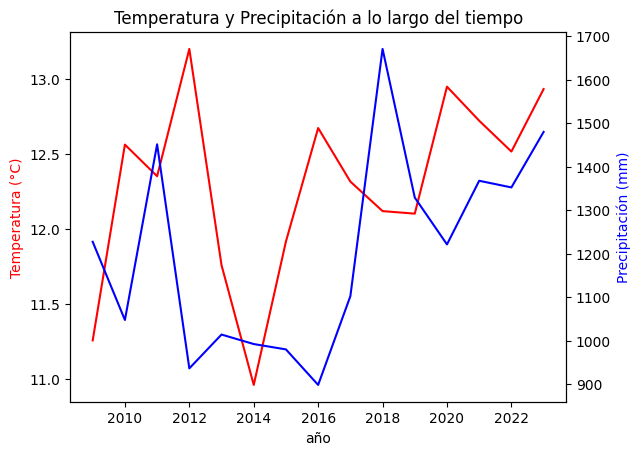

In [10]:
ax1 = sns.lineplot(data=df_grouped, x='año', y='temperature_2m_mean', color='red')

ax2 = ax1.twinx()
sns.lineplot(data=df_grouped, x='año', y='precipitation_sum', ax=ax2, color='blue')

ax1.set_ylabel('Temperatura (°C)', color='red')
ax2.set_ylabel('Precipitación (mm)', color='blue')
plt.title('Temperatura y Precipitación a lo largo del tiempo')

plt.show()